## Test Cell detection full approach

In [1]:
from test_tables import get_formatted_pdfs, parse_images
import numpy as np
from matplotlib import pyplot as plt
import os


image_to_process = []
pdf_path = "/Users/nabiltchoulak/code/ocr-recognition/tests/data/"
pdf_files_list = get_formatted_pdfs(pdf_path)
pages_collections = {}
for pdf_path in pdf_files_list:
    file_name = file_name = os.path.splitext(os.path.basename(pdf_path))[0]
    dir_path = pdf_path
    pages_collections[file_name] = parse_images(pdf_path)

Parsed 26 images from the PDF file
Parsed 24 images from the PDF file
 Wrong rotation asked for 180
 Wrong rotation asked for 180
 Wrong rotation asked for 180
Parsed 8 images from the PDF file
Parsed 24 images from the PDF file
Parsed 16 images from the PDF file


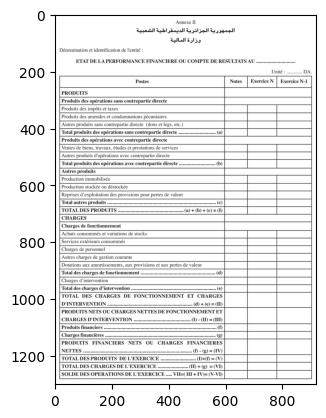

In [49]:

page_image_rgb = np.array(pages_collections["F2025009"][13])

plt.imshow(page_image_rgb)
plt.show()

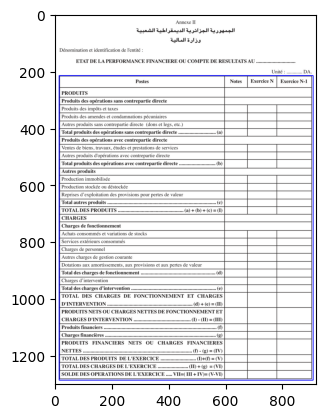

In [50]:
import cv2
from table_detection.table_detection import detect_table_from_image_data

predicted_tables, debug_table_detected_lines_image = detect_table_from_image_data(
    page_image_rgb
)

extended_lines = []
image = page_image_rgb.copy()
for key in predicted_tables.keys():    
    table_bbox = predicted_tables[key]
cv2.rectangle(
    page_image_rgb,
    (table_bbox[0], table_bbox[1]),
    (table_bbox[0] + table_bbox[2], table_bbox[1] + table_bbox[3]),
    (0, 0, 255),
    2,
)
plt.imshow(page_image_rgb)
plt.show()

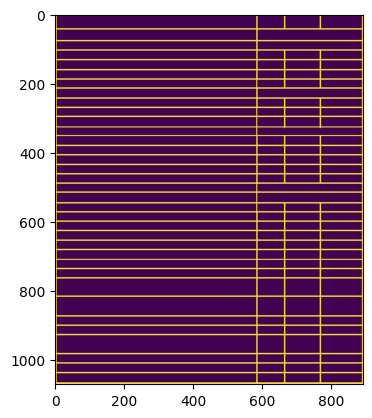

In [57]:
from table_detection.table_detection import detect_table_from_image_data, core_line_detection, display_lines
def preprocess_for_lines(img):
    # Convert to grayscale if not already
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Invert the image if text is black on white (OpenCV likes white objects)
    # We want the lines and text to be white (255)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Define a kernel for horizontal lines
    # Adjust '40' based on your image resolution; it should be longer than any single character
    h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 1))
    
    # Remove everything that isn't at least 40 pixels wide
    h_cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, h_kernel)
    
    # Repeat for vertical
    v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 15))
    v_cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, v_kernel)
    
    # Combine them back to get a "cleaned" grid for Sobel
    cleaned_grid = cv2.add(h_cleaned, v_cleaned)
    
    return cleaned_grid
np_img = np.array(image)
table_x_start = table_bbox[0]
table_y_start = table_bbox[1]
table_x_end = table_bbox[0] + table_bbox[2]
table_y_end = table_bbox[1] + table_bbox[3]
# Do the processing only inside the table
np_img_cropped = np_img[
    table_y_start:table_y_end,
    table_x_start:table_x_end,
    :,
]
preprocessed_img = preprocess_for_lines(np_img_cropped)
debug_image, vertical_lines, horizontal_lines = core_line_detection(cv2.cvtColor(preprocessed_img, cv2.COLOR_GRAY2BGR), 3, 0.03, close_gaps=True)
plt.imshow(debug_image)
plt.show()

In [54]:
import pprint
from table_detection.table_detection import TableLine, find_lines_clusters

left_line = TableLine([0, 0, 5, table_bbox[3]], init_from_bbox=True)
top_line = TableLine([0, 0, table_bbox[2], 5], init_from_bbox=True)
right_line = TableLine(
    [table_bbox[2] - 10, 0, 5, table_bbox[3]], init_from_bbox=True
)
bottom_line = TableLine(
    [0, table_bbox[3] - 10, table_bbox[2], 5], init_from_bbox=True
)

vertical_lines.sort(key=lambda line: line.x)
horizontal_lines.sort(key=lambda line: line.y)

# Add all surrounding lines
vertical_lines.insert(0, left_line)
horizontal_lines.insert(0, top_line)
vertical_lines.insert(-1, right_line)
horizontal_lines.insert(-1, bottom_line)

## Step 2

def get_minimal_line_diff_distance(v_lines, h_lines):
    assert len(h_lines) > 1 and len(v_lines) > 1
    prev_line = v_lines[0]
    # random number to start with
    current_min = 1000
    for i, line in v_lines.items():
        if i == 0:
            continue
        current_min = min(abs(prev_line[0].x - line[0].x), current_min)
        prev_line = line
    prev_line = h_lines[0]
    for i, line in h_lines.items():
        if i == 0:
            continue
        current_min = min(abs(prev_line[0].y - line[0].y), current_min)
        prev_line = line
    return current_min

# Remove duplicate lines:
vertical_clusters = find_lines_clusters(vertical_lines, 0.01 * table_bbox[3])
horizontal_clusters = find_lines_clusters(horizontal_lines, 0.01 * table_bbox[2])
print(
    f"At the start, the following line clusters are detected: \n"
    "Vertical Clusters: "
    + pprint.pformat(f"{vertical_clusters}")
    + "\nHorizontal Clusters: "
    + pprint.pformat(f"{horizontal_clusters}")
)

At the start, the following line clusters are detected: 
Vertical Clusters: ('{0: [[0, 0, 5, 1070], [0, 0, 5, 1070], (0, 0, 5, 1070)], 1: [(581, 0, 4, '
 '1070)], 2: [(661, 547, 4, 523), (661, 350, 4, 140), (661, 244, 4, 86), (661, '
 '105, 4, 110), (661, 0, 4, 44)], 3: [(764, 547, 4, 523), (764, 350, 4, 140), '
 '(764, 244, 4, 86), (764, 105, 4, 110), (764, 0, 4, 44)], 4: [[882, 0, 5, '
 '1070], [882, 0, 5, 1070], (886, 0, 6, 1070)]}')
Horizontal Clusters: ('{0: [[0, 0, 892, 5], [0, 0, 892, 5], (0, 0, 892, 5)], 1: [(0, 41, 892, 4)], '
 '2: [(0, 75, 892, 4)], 3: [(0, 102, 892, 4)], 4: [(0, 130, 892, 4)], 5: [(0, '
 '159, 892, 4)], 6: [(0, 186, 892, 4)], 7: [(0, 212, 892, 4)], 8: [(0, 241, '
 '892, 4)], 9: [(0, 268, 892, 4)], 10: [(0, 294, 892, 4)], 11: [(0, 325, 892, '
 '3)], 12: [(0, 350, 892, 3)], 13: [(0, 378, 892, 4)], 14: [(0, 405, 892, 4)], '
 '15: [(0, 433, 892, 4)], 16: [(0, 460, 892, 4)], 17: [(0, 487, 892, 4)], 18: '
 '[(0, 513, 892, 4)], 19: [(0, 544, 892, 4)], 20: [(0, 570,

In [ ]:
import cv2
from table_detection.table_detection import detect_table_from_image_data, core_line_detection, display_lines

table_x_start = table_bbox[0]
table_y_start = table_bbox[1]
table_x_end = table_bbox[0] + table_bbox[2]
table_y_end = table_bbox[1] + table_bbox[3]
left_line = (0, 0, 5, table_bbox[3])
top_line = (0, 0, table_bbox[2], 5)
right_line = (table_bbox[2] - 10, 0, 5, table_bbox[3])
bottom_line = (0, table_bbox[3] - 10, table_bbox[2], 5)



np_img = np.array(image)
# Do the processing only inside the table
np_img_cropped = np_img[
    table_y_start:table_y_end,
    table_x_start:table_x_end,
    :,
]
extension_amount=15.0

combined_grid, contours_v, contours_h = core_line_detection(np_img_cropped, 3, 10)

vertical_lines = [cv2.boundingRect(cnt) for cnt in contours_v]

horizontal_lines = [cv2.boundingRect(cnt) for cnt in contours_h]

vertical_lines.sort(key=lambda c: c[0])
horizontal_lines.sort(key=lambda c: c[1])


# Add all surrounding lines
vertical_lines.insert(0, left_line)
horizontal_lines.insert(0, top_line)
vertical_lines.insert(-1, right_line)
horizontal_lines.insert(-1, bottom_line)

lines = [(line[0], line[1], line[0] + line[2], line[1] + line[3]) for line in [*vertical_lines, *horizontal_lines]]

lines_img = display_lines(lines,np_img_cropped)

plt.imshow(lines_img)
plt.show()

In [ ]:


def remove_line_duplicates(line_clusters, axis):
    secondary_axis = (axis + 1) % 2
    for cluster_key in line_clusters.keys():
        if len(line_clusters[cluster_key]) == 1:
            continue
        prev_line  = line_clusters[cluster_key][0]
        filtered_lines = [line_clusters[cluster_key][0]]
        for i,line in enumerate(line_clusters[cluster_key]):
            if i==0:
                continue
            # Only remove lines that have the same starting point
            print(f"Comparing lines: {line} and {prev_line} on axis {secondary_axis}")
            if abs(line[secondary_axis] - prev_line[secondary_axis]) > line[secondary_axis + 2]:
                filtered_lines.append(line)
                print("retained")            
            prev_line = line       
        line_clusters[cluster_key] = filtered_lines


def get_minimal_line_diff_distance(v_lines, h_lines):
    assert len(h_lines) > 1 and len(v_lines) > 1
    prev_line = v_lines[0]
    # random number to start with
    current_min = 1000
    for i,line in v_lines.items():
        if i ==0:
            continue
        current_min = min(abs(prev_line[0][0] - line[0][0]), current_min)
        prev_line = line
    prev_line = h_lines[0]
    for i,line in h_lines.items():
        if i ==0:
            continue
        current_min = min(abs(prev_line[0][1] - line[0][1]), current_min)
        prev_line = line
    return current_min

        
# Remove duplicate lines:
vertical_clusters = find_clusters_1d_arrays(vertical_lines, 0.01*table_bbox[3])        
horizontal_clusters = find_clusters_1d_arrays(horizontal_lines, 0.01*table_bbox[2], 1, 1)

remove_line_duplicates(vertical_clusters, 0)
remove_line_duplicates(horizontal_clusters, 1)
    

new_lines = [(line[0][0], line[0][1], line[0][0] + line[0][2], line[0][1] + line[0][3]) for _,line in vertical_clusters.items()]

for _, lines in horizontal_clusters.items():
    for line in lines:
        new_lines.append((line[0], line[1], line[0] + line[2], line[1] + line[3]))

new_lines_img = display_lines(new_lines,np_img_cropped)

min_line_distance = get_minimal_line_diff_distance(vertical_clusters, horizontal_clusters)

# 1. Combine the horizontal and vertical line images
# table_grid = cv2.bitwise_or(morphed_horizontal, morphed_vertical)

# 2. Morphological Close ("Smear" the lines together)
# This is the most important parameter to tune.
# (25, 25) means it will connect lines that are up to 25px apart.
# Expirementation showed that using min distance between lines minus 
# a gap works the best

kernel_size = (25, 25)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)

# "Closing" = Dilate (thicken) then Erode (thin)
# This fills gaps and connects nearby lines.
closed_grid = cv2.morphologyEx(new_lines_img, cv2.MORPH_CLOSE, kernel)

plt.imshow(closed_grid)
plt.show()

In [ ]:
np_img_cropped = np_img[
    table_y_start:table_y_end,
    table_x_start:table_x_end,
    :,
].copy()
contours, hierarchy = cv2.findContours(
        closed_grid, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE
    )
table_bounding_boxes = []
for cnt in contours:
    # 4. Get the bounding box for each blob
    bbox = cv2.boundingRect(cnt)
    if (bbox[3]/table_bbox[3] < 0.02 or bbox[2]/table_bbox[2] < 0.02):
            continue
    cv2.rectangle(
                    np_img_cropped,
                    (bbox[0], bbox[1]),
                    (bbox[0] + bbox[2], bbox[1] + bbox[3]),
                    (0, 0, 255),
                    3,
                )
    
plt.imshow(np_img_cropped)
plt.show()

In [ ]:
import os
pdf_path = "/Users/nabiltchoulak/code/ocr-recognition/data_test/F1962008.pdf"
dir_path = 
dir_path